# Implementing Advantage-Actor Critic (A2C)

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel. 

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscal, take max between frames, skip frames and stack them together) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function. Note that if you are using 
PyTorch and not using `tensorboardX` you will need to implement a wrapper that will log **raw** total rewards that the *unwrapped* environment returns and redefine the implemention of `nature_dqn_env` function here. 



In [1]:
import numpy as np
from atari_wrappers import nature_dqn_env, NumpySummaries
import matplotlib.pyplot as plt
env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=8, summaries='Numpy')
obs = env.reset()
assert obs.shape == (8, 84, 84, 4)
assert obs.dtype == np.uint8

Next, we will need to implement a model that predicts logits and values. It is suggested that you use the same model as in [Nature DQN paper](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) with a modification that instead of having a single output layer, it will have two output layers taking as input the output of the last hidden layer. **Note** that this model is different from the model you used in homework where you implemented DQN. You can use your favorite deep learning framework here. We suggest that you use orthogonal initialization with parameter $\sqrt{2}$ for kernels and initialize biases with zeros. 

In [2]:
# import tensorflow as torch
# import torch as tf
import torch
import torch.nn as nn
import torch.nn.functional as F

# <Define your model here>
def ortho_weights(shape, scale=1.):
    """ PyTorch port of ortho_init from baselines.a2c.utils """
    shape = tuple(shape)

    if len(shape) == 2:
        flat_shape = shape[1], shape[0]
    elif len(shape) == 4:
        flat_shape = (np.prod(shape[1:]), shape[0])
    else:
        raise NotImplementedError

    a = np.random.normal(0., 1., flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.transpose().copy().reshape(shape)

    if len(shape) == 2:
        return torch.from_numpy((scale * q).astype(np.float32))
    if len(shape) == 4:
        return torch.from_numpy((scale * q[:, :shape[1], :shape[2]]).astype(np.float32))


def atari_initializer(module):
    """ Parameter initializer for Atari models
    Initializes Linear, Conv2d, and LSTM weights.
    """
    classname = module.__class__.__name__

    if classname == 'Linear':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'Conv2d':
        module.weight.data = ortho_weights(module.weight.data.size(), scale=np.sqrt(2.))
        module.bias.data.zero_()

    elif classname == 'LSTM':
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'weight_hh' in name:
                param.data = ortho_weights(param.data.size(), scale=1.)
            if 'bias' in name:
                param.data.zero_()
                

class Network(nn.Module):
    
    def __init__(self, shape_in, action_shape):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(shape_in, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.dense1 = nn.Linear(64*7*7, 512)
        self.dense2 = nn.Linear(512, action_shape)
        self.dense3 = nn.Linear(512, 1)
        self.apply(atari_initializer)
        self.dense2.weight.data = ortho_weights(self.dense2.weight.size(), scale=.01)
        self.dense3.weight.data = ortho_weights(self.dense3.weight.size())
        
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.dense1(x))
        logits = self.dense2(x)
        values = self.dense3(x)
        return logits, values

You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a dictionary of all the arrays that are needed to interact with an environment and train the model.
 Note that actions must be an `np.ndarray` while the other
tensors need to have the type determined by your deep learning framework. 

In [3]:
device = torch.device('cuda')

In [4]:
class Policy:
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def act(self, inputs):
#         <Implement policy by calling model, sampling actions and computing their log probs>
#          Should return a dict containing keys ['actions', 'logits', 'log_probs', 'values'].
        inputs = torch.tensor(inputs, dtype=torch.float32, device=device)
        inputs = torch.transpose(inputs/255., 3, 1)
        logits, values = self.model(inputs)
        dist = torch.distributions.Categorical(logits=logits)
        actions = dist.sample().view(-1, 1)[:, 0]
        actions = actions.cpu().detach().numpy()
        probs = F.softmax(logits, -1)
        logprobs = F.log_softmax(logits, -1)
        logp_actions = torch.sum(logprobs * F.one_hot(torch.tensor(actions, device=device), n_actions), axis=-1)
        return {'actions': actions,
                'logits': logits,
                'values': values,
                'probs': probs,
                'log_probs': logprobs,
                'log_probs_actions':logp_actions}

Next will pass the environment and policy to a runner that collects partial trajectories from the environment. 
The class that does is is already implemented for you.

In [5]:
from runners import EnvRunner

This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys 

* 'observations' 
* 'rewards' 
* 'resets'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment of specified length $T$ &mdash; the size of partial trajectory. 

To train the part of the model that predicts state values you will need to compute the value targets. 
Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected. 
Thus, we can implement and use `ComputeValueTargets` callable. 
The formula for the value targets is simple:

$$
\hat v(s_t) = \left( \sum_{t'=0}^{T - 1 - t} \gamma^{t'}r_{t+t'} \right) + \gamma^T \hat{v}(s_{t+T}),
$$

In implementation, however, do not forget to use 
`trajectory['resets']` flags to check if you need to add the value targets at the next step when 
computing value targets for the current step. You can access `trajectory['state']['latest_observation']`
to get last observations in partial trajectory &mdash; $s_{t+T}$.

In [6]:
class ComputeValueTargets:
    def __init__(self, policy, gamma=0.99):
        self.policy = policy
        self.gamma = gamma
    
    def __call__(self, trajectory):
        # This method should modify trajectory inplace by adding
        # an item with key 'value_targets' to it.
        #<Compute value targets for a given partial trajectory>   
        value_target = policy.act(trajectory['state']['latest_observation'])['values'][:, 0]
        env_steps = trajectory['state']['env_steps']
        rewards = torch.tensor(trajectory['rewards'], dtype=torch.float32, device=device)
        dones = torch.tensor(trajectory['resets'], dtype=torch.float, device=device)
        is_not_done = 1 - dones
        trajectory['value_targets'] = [0] * env_steps
        for i in range(env_steps):
            j = env_steps - i - 1
            value_target = rewards[j] + value_target * self.gamma * is_not_done[j]
            trajectory['value_targets'][j] = value_target


After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `T * nenvs`, i.e. you essentially need
to flatten the first two dimensions. 

In [7]:
class MergeTimeBatch:
    """ Merges first two axes typically representing time and env batch. """
    def __call__(self, trajectory):
        # Modify trajectory inplace.
        #<TODO: implement>
        trajectory['actions'] = np.array(trajectory['actions']).flatten()
        trajectory['logits'] = torch.stack(trajectory['logits']).flatten(0, 1)
        trajectory['probs'] = torch.stack(trajectory['probs']).flatten(0, 1)
        trajectory['log_probs'] = torch.stack(trajectory['log_probs']).flatten(0, 1)
        trajectory['log_probs_actions'] = torch.cat(trajectory['log_probs_actions'])
        trajectory['values'] = torch.cat(trajectory['values'])[:, 0]
        trajectory['value_targets'] = torch.cat(trajectory['value_targets'])
        trajectory['observations'] = np.concatenate(trajectory['observations'])
        trajectory['rewards'] = np.concatenate(trajectory['rewards'])
        trajectory['resets'] = np.array(trajectory['resets']).flatten()

In [8]:
n_actions = env.action_space.n
model = Network(shape_in=4, action_shape=env.action_space.n).to(device) #<Create your model here>
policy = Policy(model, device=device)
runner = EnvRunner(
    env, policy, nsteps=5,
    transforms=[
        ComputeValueTargets(policy),
        MergeTimeBatch(),
    ])

In [9]:
# runner.get_next()['actions'].shape
# runner.get_next()['logits'].shape
print(runner.get_next()['log_probs'].shape)
# runner.get_next()['values'].shape
print(runner.get_next()['value_targets'].shape)

torch.Size([40, 6])
torch.Size([40])


Now is the time to implement the advantage actor critic algorithm itself. You can look into your lecture,
[Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and [lecture](https://www.youtube.com/watch?v=Tol_jw5hWnI&list=PLkFD6_40KJIxJMR-j5A1mkxK26gh_qg37&index=20) by Sergey Levine.

In [10]:
class A2C:
    def __init__(self, policy, optimizer, value_loss_coef=0.25, entropy_coef=0.02, max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
    
    def policy_loss(self, trajectory):
        # You will need to compute advantages here.
#         <TODO: implement>
        A = (trajectory['value_targets'] - trajectory['values']).detach()
        self.advantages_np = A.mean().cpu().numpy()
        self.policy_loss_np = -torch.mean(A*trajectory['log_probs_actions']).detach().mean().cpu().numpy()
        return -torch.mean(A*trajectory['log_probs_actions'])
    
    def value_loss(self, trajectory):
#         <TODO: implement>
        self.values_np = trajectory['values'].detach().mean().cpu().numpy()
        self.value_targets_np = trajectory['value_targets'].detach().mean().cpu().numpy()
        value_loss = torch.mean((trajectory['values'] - trajectory['value_targets'].detach())**2)
        self.value_loss_np = value_loss.detach().mean().cpu().numpy()
        return value_loss
    
    def loss(self, trajectory):
#         <TODO: implement>
        entropy = - torch.mean(torch.sum(trajectory['probs']*trajectory['log_probs'], 1))
        self.entropy_np = entropy.detach().cpu().numpy()
        loss = self.policy_loss(trajectory) +\
          self.value_loss_coef*self.value_loss(trajectory) - self.entropy_coef*entropy 
        self.a2c_loss_np = loss.detach().cpu().numpy()
        return loss
        
      
    def step(self, trajectory):
#         <TODO: implement>
        self.optimizer.zero_grad()
        self.loss(trajectory).backward()
        torch.nn.utils.clip_grad_norm_(policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        self.total_norm = 0
        for p in policy.model.parameters():
            param_norm = p.grad.data.norm(2)
            self.total_norm += param_norm.item() ** 2
        self.total_norm = self.total_norm ** (1. / 2)

Now you can train your model. With reasonable hyperparameters training on a single GTX1080 for 10 million steps across all batched environments (which translates to about 5 hours of wall clock time)
it should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last 
episodes in each environment in the batch) of about 600. You should plot this quantity with respect to 
`runner.step_var` &mdash; the number of interactions with all environments. It is highly 
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between 
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages
* A2C loss

For optimization we suggest you use RMSProp with learning rate starting from 7e-4 and linearly decayed to 0, smoothing constant (alpha in PyTorch and decay in TensorFlow) equal to 0.99 and epsilon equal to 1e-5.

In [11]:
def evaluate(env, agent, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """
    agent.train(False)
    game_rewards = []
    done_counter = 0
    for _ in range(n_games):
        state = env.reset()
        total_reward = 0
        while True:
            state = torch.tensor(state, dtype=torch.float32, device=device) / 255.
            state = torch.transpose(state, 3, 1)
            logits, _ = agent(state)
            logits = logits[0]
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample().view(-1, 1)
            action = action.cpu().detach().numpy()
            state, reward, done, info = env.step([action]*8)
            total_reward += reward[0]
            if done[0]:
                break
        game_rewards.append(total_reward)
    agent.train(True)
    return game_rewards

In [12]:
# evaluate(model, n_games=3)
optimizer = torch.optim.RMSprop(model.parameters(), lr=7e-4, alpha=0.99, eps=1e-5)

In [13]:
from IPython.display import clear_output
from tqdm import trange

In [14]:
def plot_tools(legend, position, data_y):
    plt.subplot(2,4,position)
    plt.plot(data_y, label=legend)
    plt.title(legend); plt.grid(); plt.legend() 
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

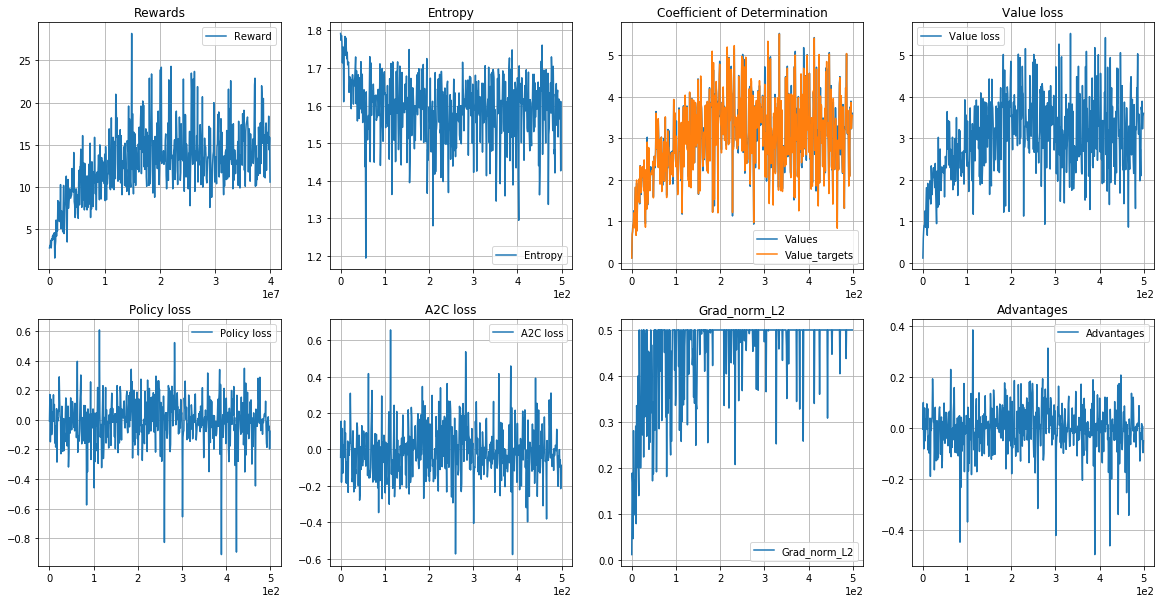

100%|██████████| 1000000/1000000 [13:59:50<00:00, 19.85it/s]


In [15]:
a2c = A2C(policy, optimizer) #<Create instance of the algorithm> 
# <Write your training loop>
num_steps = []
rewards = []
entropies = []
value_losses = []
policy_losses = []
values =[]
value_targets = []
grad_norms = []
advantages = []
a2c_losses = []
DECAY = 10_000_000
for i in trange(1_000_000):
    trajectory = runner.get_next()
    a2c.step(trajectory)
    
    if i%2000==0:
        clear_output(True)
        
        entropies.append(a2c.entropy_np)
        value_losses.append(a2c.values_np)
        policy_losses.append(a2c.policy_loss_np)
        values.append(a2c.values_np)
        value_targets.append(a2c.value_targets_np)
        grad_norms.append(a2c.total_norm)
        advantages.append(a2c.advantages_np)
        a2c_losses.append(a2c.a2c_loss_np)
        
        rewards.append(np.mean(evaluate(env, model, n_games=10)))
        
        num_steps.append(runner.step_var)
        
        plt.figure(figsize=[20,10])
        plt.subplot(2,4,1)
        plt.plot(num_steps, rewards, label='Reward')
        plt.title("Rewards"); plt.grid(); plt.legend()
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        plot_tools('Entropy', 2, entropies)

        plt.subplot(2,4,3)
        plt.plot(values, label='Values')
        plt.plot(value_targets, label='Value_targets')
        plt.title("Coefficient of Determination"); plt.grid(); plt.legend()
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        plot_tools('Value loss', 4, value_losses)

        plot_tools('Policy loss', 5, policy_losses)

        plot_tools('A2C loss', 6, a2c_losses)
        
        plot_tools('Grad_norm_L2', 7, grad_norms) 
        
        plot_tools('Advantages', 8, advantages)

        plt.show()

In [18]:
np.mean(evaluate(env, model, n_games=100))

17.74